In [310]:
%matplotlib inline 
import pandas
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors

In [311]:
def prepare_df(out_trace_file):
    """Reads an output trace file into a dataframe and translates the time columns 
    so the minimum time occurring is 0
    
    Parameters:
    -----------
    out_trace_file : str
        Path to the output trace file from a simulation run
        
    Returns:
    -------
    df : pandas.DataFrame
        dataframe containing the fields from the output trace file"""
    df = pandas.read_csv(out_trace_file)
    min_time = min(df["submit_time_ms"])
    df["start_time_ms"] =df["start_time_ms"]-min_time
    df["end_time_ms"] =df["end_time_ms"]-min_time
    df["submit_time_ms"] = df["submit_time_ms"]-min_time
    df["mesos_start_time_ms"] = df["mesos_start_time_ms"] - min_time
    df["run_time_ms"] = df.end_time_ms - df.start_time_ms
    return df

def job_view_stats(df):
    """Produces a dataframe that is focused on the job level. 
    Each row is a job, the task id is the last task that ran and 'overhead'
    is (end_time_ms-submit_time_ms)-run_time_ms. 
    This measures the added cost from the scheduler and lack of infinite compute.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        dataframe returned from prepare_df
        
    Returns:
    --------
    df : pandas.DataFrame
        dataframe with job level info"""
    df = df.copy()
    df = df.sort_values("end_time_ms").groupby("job_id").last()
    df["submit_to_complete_ms"] = df.end_time_ms - df.submit_time_ms
    df["overhead"] = df.submit_to_complete_ms - df.run_time_ms
    df.reset_index(inplace=True)
    return df

def compare_job_traces(run_x, run_y):
    """Given two dfs, run_x and run_y from job_view_stats,
    returns a single dataframe where each row is comparing
    the same job. Adds column 'ratio' which informs how many times better
    run_y was compared to run_x for that job. For example, if job A had an 
    overhead of 5 seconds in run_y and an overhead of 10 seconds in run_x, than
    ratio for job A would be 2, i.e. job A suffered 2x less overhead in run_y 
    than in run_x
    
    Parameters:
    -----------
    run_x : pandas.DataFrame
        job_view_stats outputted dataframe
    run_y : pandas.DataFrame
        job_view_stats outputted dataframe
        
    Returns:
    --------
    df : pandas.DataFrame
        joined dataframe of run_x and run_y with ratio column"""
    compare_df = run_x.merge(run_y, on="job_id")
    compare_df["ratio"] = compare_df.overhead_x/compare_df.overhead_y
    return compare_df

def running_tasks_at(df, t):
    """Returns the tasks running at t
    
    Parameters:
    -----------
    df : pandas.DataFrame
        prepare_df outputted dataframe
    t : int
        time in milliseconds (in translated time)
        
    Returns:
    --------
    pandas.DataFrame
        dataframe with same form as df, but only with tasks that were running at t"""
    df = df.copy()
    started_before_df = df[df.start_time_ms <= t]
    completed_after_df = started_before_df[started_before_df.end_time_ms > t]
    return completed_after_df
    
def analyze_state(df, t):
    """Returns the 5 dataframes with analysis for a particular point in time
    
    Parameters:
    -----------
    df : pandas.DataFrame
        prepare_df outputted dataframe
    t : int
        time in milliseconds (in translated time)
        
    Returns:
    --------
    per_host : pandas.DataFrame
        dataframe with a row per host. Has column for mem, cpus and count 
        of tasks running on the host
    per_user : pandas.DataFrame
        dataframe with a row per user. Has a column for mem, cpus and count
        of tasks running for the user
    waiting : pandas.DataFrame
        dataframe with a row for tasks that were submitted before t but were 
        not running at t. 
    running_tasks_df : pandas.DataFrame
        dataframe outputted by running_tasks_at
    df : pandas.DataFrame
        input dataframe
        """
    state_df = running_tasks_at(df, t)
    state_df["count"] = 1
    per_host = state_df.groupby("hostname").sum()[["mem", "cpus", "count"]]
    per_user = state_df.groupby("user").sum()[["mem", "cpus", "count"]]
    waiting = df[(df.submit_time_ms < t) & (df.start_time_ms > t)]
    return [per_host, per_user, waiting, state_df, df]


def gantt_plot(names, starts, ends, colors=None, groups=None, texts=None):
    if colors is None:
        if groups is None:
            c_map = plt.get_cmap("jet")
            cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=len(starts))
            scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=c_map)
            colors = [scalarMap.to_rgba(i) for i in range(len(starts))]
    names = names.values
    unique_names, index =  np.unique(names, return_index=True)
    unique_names = list(names[sorted(index)])
    #This is O(nm) where n is names and m is unique names. Can optimize
    plt.barh(bottom=[unique_names.index(name) for name in names], left=starts, width=ends-starts, color=colors)
    if texts is not None:
        for i, text in enumerate(texts):
            plt.text(np.mean([starts[i]]), unique_names.index(names[i]), text, 
                       verticalalignment='center', fontsize=30)
    
def colors_for_values(vs):
    unique_vs = list(np.unique(vs))
    c_map = plt.get_cmap("jet")
    cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_vs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=c_map)
    return [scalarMap.to_rgba(unique_vs.index(v)) for v in vs]



def running_concurrently(df):
    """Given a dataframe of tasks, returns a dataframe where each row 
    is the utilization at a given time
    
     
     Parameters:
     -----------
     df : pandas.DataFrame
         dataframe output from prepare_df
         
     Returns:
     --------
     pandas.DataFrame
         dataframe time series of utilization with keys 
         'time_ms', 'count', 'cpus', 'mem'
         where 
         1. 'count' is the number of tasks running
         2. 'mem' is the memory utilized 
         3. 'cpus' is the cpus utilized
         at time 'time_ms'."""
    rows = df.to_records()
    events = [e for r in rows for e in [(r["start_time_ms"], 1, r["mem"], r["cpus"]), 
                                        (r["end_time_ms"], -1, -r["mem"], -r["cpus"])]]
    ordered_events = sorted(events, key=lambda x: x[0])
    time_series = []
    count_total = 0
    mem_total = 0
    cpus_total = 0
    for time, count, mem, cpus in ordered_events:
        count_total += count
        mem_total += mem
        cpus_total += cpus
        time_series.append({"time_ms" : time, "count" : count_total, "cpus" : cpus_total, "mem": mem_total})
    return pandas.DataFrame(time_series)

# Single simulation analysis

In [347]:
df = prepare_df("simulator_files/experiments/big/out-trace.csv")
df.head()

,job_id,instance_id,submit_time_ms,mesos_start_time_ms,start_time_ms,end_time_ms,hostname,slave_id,status,reason,user,mem,cpus,job_name,requested_run_time,requested_status,run_time_ms
0,58fe598f-2c89-4022-a735-f1c5c3d59b97,d6a74344-fc26-40cc-b626-2478c5cbafad,2350011,2350063,2350063,2450001,19,7a6a5518-2ed3-440c-b058-e176089758ba,:instance.status/success,NaN,b,3125.0,2.0,dummy_job,380427/5,finished,99938
1,58fe598f-d5bf-4bcc-8430-702238cfe5c5,96e61d0f-1db7-4df9-b083-a88aa55f69eb,2350005,2350063,2350063,2375001,19,7a6a5518-2ed3-440c-b058-e176089758ba,:instance.status/success,NaN,a,2540.0,2.0,dummy_job,213777/10,finished,24938
2,58fe598f-693e-4571-9100-8537ce1f0ac4,ab17f4e6-bc6f-47f4-9d6d-348d62d9f61d,2350016,2350063,2350063,2450001,19,7a6a5518-2ed3-440c-b058-e176089758ba,:instance.status/success,NaN,c,2640.0,3.0,dummy_job,477006/5,finished,99938
3,58fe598f-b5fc-4881-b1c1-9184744db2b6,9e26f2b2-a193-45b4-b14f-7b80f04c8965,2350014,2350063,2350063,2400001,1,1b898b4c-7f41-4b08-8bd3-4637d5245d4b,:instance.status/success,NaN,c,3109.0,3.0,dummy_job,468303/10,finished,49938
4,58fe598f-bb5f-4f3c-aaa3-295a4b2dd0e1,43bf187a-12d2-4d6f-b264-aa66b073557c,2350013,2350063,2350063,2425056,1,1b898b4c-7f41-4b08-8bd3-4637d5245d4b,:instance.status/success,NaN,c,2082.0,1.0,dummy_job,56776,finished,74993


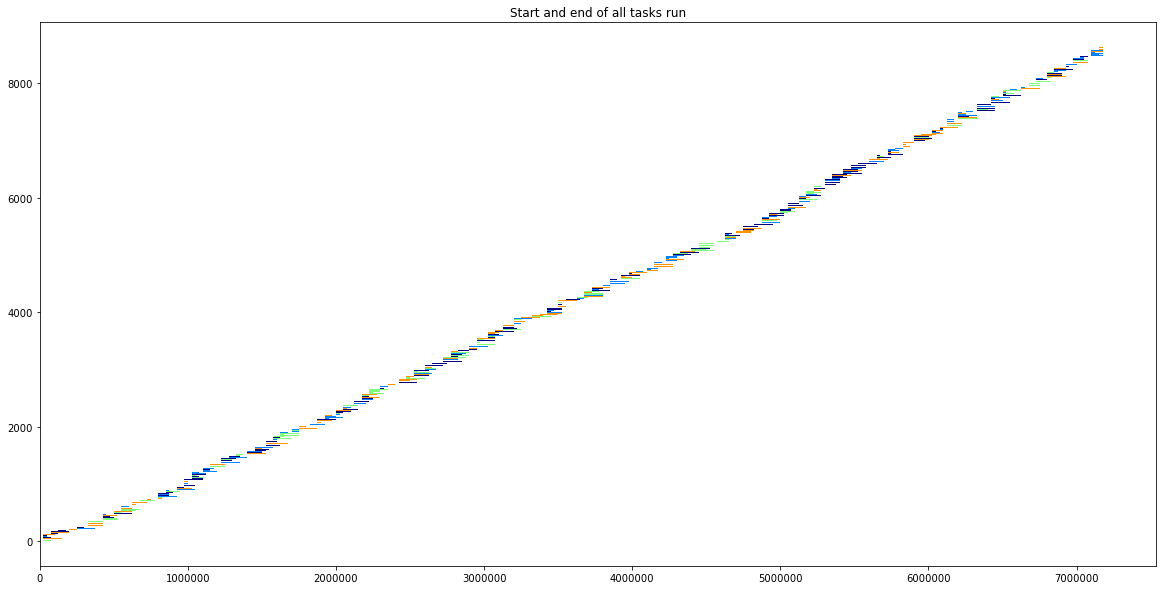

In [345]:
df = df.sort_values("start_time_ms", ascending=True).reset_index(drop=True)
plt.figure(figsize=(20,10))
gantt_plot(df.job_id, df.start_time_ms, df.end_time_ms, colors_for_values(df.user), texts = ["X" if status == ":instance.status/failed" else "" for status in df.status])
plt.title("Start and end of all tasks run")

In [349]:
utilization_ts = running_concurrently(df)
utilization_ts["cycle"] = np.floor(utilization_ts.time_ms/1000) # This assumes cycle is > 1000ms
utilization_ts = utilization_ts.groupby("cycle").last().reset_index(drop=True)

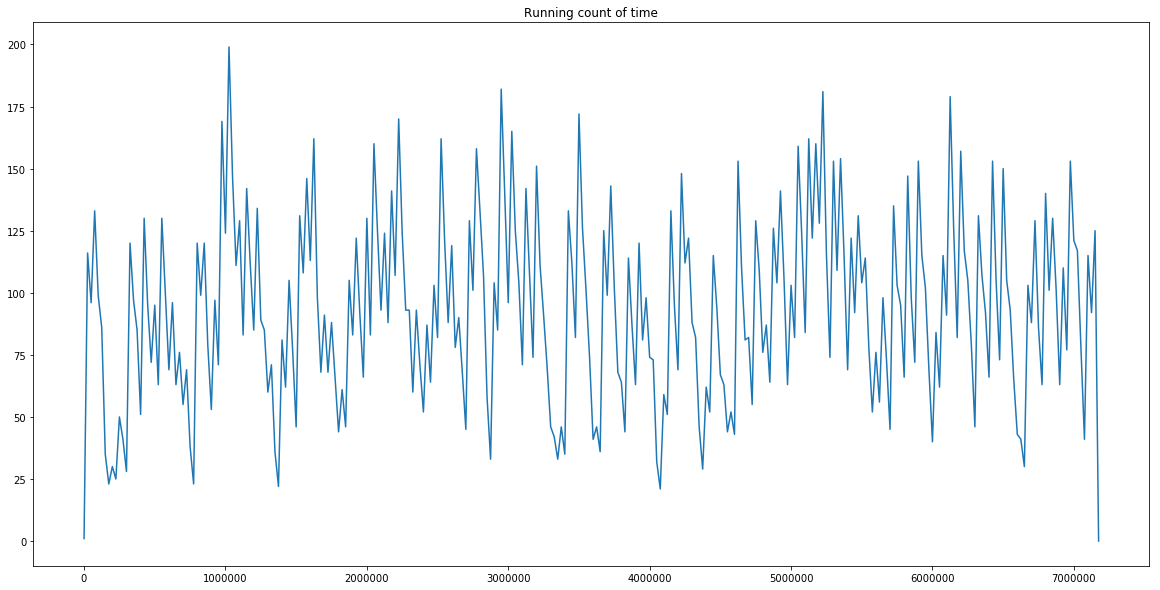

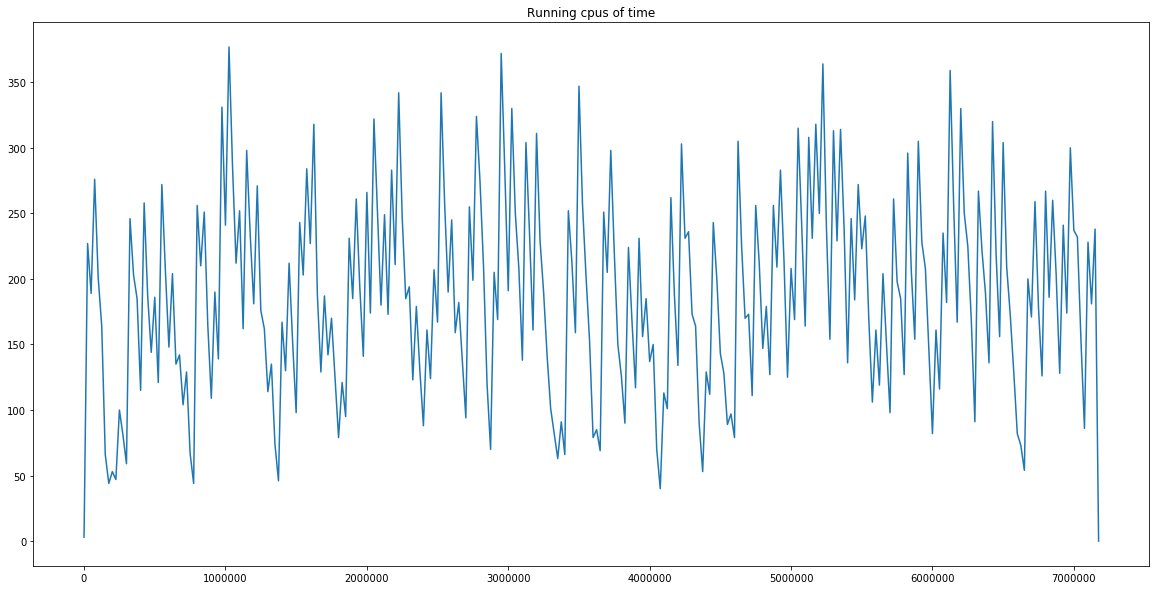

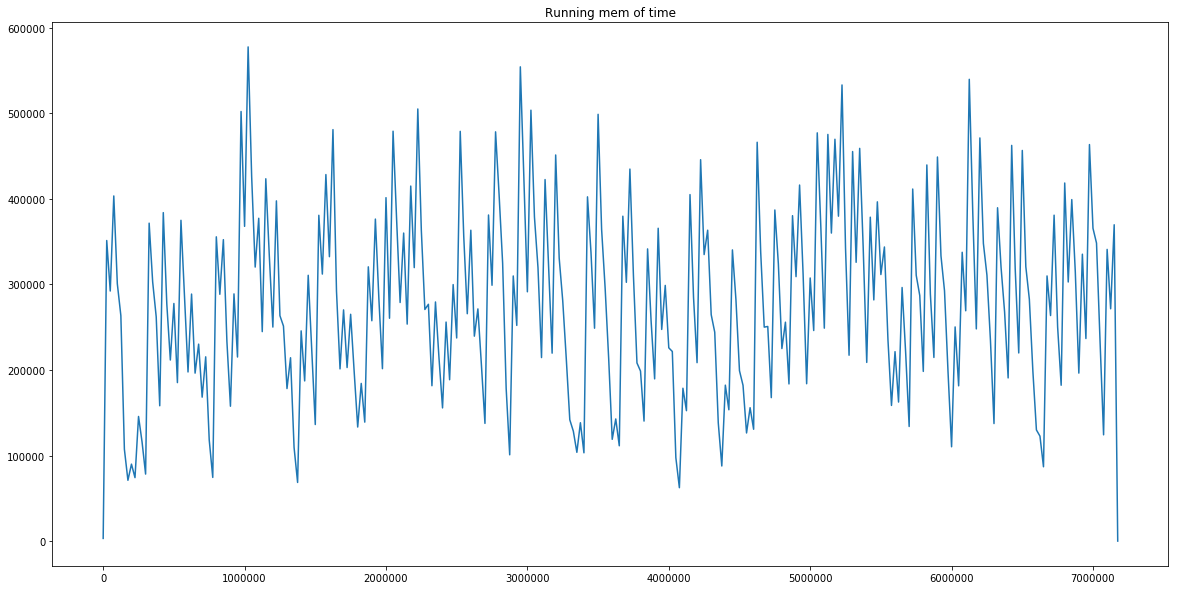

In [350]:
plt.figure(figsize=(20,10))
plt.plot(utilization_ts["time_ms"], utilization_ts["count"])
plt.title("Running count of time")
plt.figure(figsize=(20,10))
plt.plot(utilization_ts["time_ms"], utilization_ts["cpus"])
plt.title("Running cpus of time")
plt.figure(figsize=(20,10))
plt.plot(utilization_ts["time_ms"], utilization_ts["mem"])
plt.title("Running mem of time")

## Point in time analysis

In [317]:
[per_host, per_user, waiting, running_at, df] = analyze_state(df, df.start_time_ms.median())

In [318]:
per_host

,mem,cpus,count
hostname,,,
0,19073.0,20.0,9
1,11753.0,20.0,6
2,13499.0,20.0,7
3,16753.0,20.0,9
4,19425.0,16.0,10


In [319]:
per_user

,mem,cpus,count
user,,,
a,26277.0,38.0,14
b,15935.0,19.0,8
c,14058.0,11.0,7
d,24233.0,28.0,12


In [320]:
waiting

,job_id,instance_id,submit_time_ms,mesos_start_time_ms,start_time_ms,end_time_ms,hostname,slave_id,status,reason,user,mem,cpus,job_name,requested_run_time,requested_status,run_time_ms
1070,58f8f051-330f-4166-8c0a-bb09e933bf23,b1559aca-2b9b-4b1d-acb9-07eb91b17259,975017,1000003,1000003,1025092,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,2668.0,2.0,dummy_job,51022/5,finished,25089
1072,58f8f051-a3ab-421a-b529-b4e96fd0cbbc,f6d216f0-6162-4190-8f17-5bae22bb6d05,975019,1000003,1000003,1050001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,1101.0,3.0,dummy_job,52119/2,finished,49998
1074,58f8f051-d333-4dff-8ed7-82c1ca4d79cb,360ffb00-eac8-4750-88ac-c9d8080a07cd,975018,1000003,1000003,1050001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,1684.0,2.0,dummy_job,199951/5,finished,49998
1076,58f8f051-057f-4166-a7d0-9e80b139e90f,3ecbaddd-f67a-42ec-ab3a-30f604f2f29a,975030,1000003,1000003,1025092,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,a,2009.0,1.0,dummy_job,159881/10,finished,25089
1079,58f8f051-ffc9-4cf5-929c-98c58da18603,00045956-684f-4764-9687-a7514e45d765,975025,1000003,1000003,1075001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,a,1429.0,1.0,dummy_job,63415,finished,74998
1080,58f8f051-2090-4e14-af98-6f3faeb563e5,b71f2aee-9c56-46a0-b775-2f46f18d6df2,975023,1000003,1000003,1050001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,a,1679.0,2.0,dummy_job,159848/5,finished,49998
1078,58f8f051-df85-4829-96e8-621f1294c19a,dfefbda2-9dac-47ea-9075-abdf065f8569,975027,1000003,1000003,1050001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,d,1830.0,1.0,dummy_job,256277/10,finished,49998


In [321]:
running_at

,job_id,instance_id,submit_time_ms,mesos_start_time_ms,start_time_ms,end_time_ms,hostname,slave_id,status,reason,user,mem,cpus,job_name,requested_run_time,requested_status,run_time_ms,count
819,58f8f051-b5fb-4704-8c1a-990fe1188f0a,9c0ca29d-5a17-4fb7-8c70-1a4ff672d6eb,925005,925023,925023,1000001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,b,1672.0,4.0,dummy_job,282314/5,finished,74978,1
831,58f8f051-3bbe-44e1-a1cd-ee36b71f69aa,622d832a-1b30-4eb7-aaa7-585e23c472e2,850064,925023,925023,1000001,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,d,2462.0,1.0,dummy_job,100999/2,finished,74978,1
832,58f8f051-09d1-48c5-a985-5b9edec8a8c5,fa74634d-28fe-4241-93ab-a4e0d64ad173,925003,925023,925023,1000001,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,b,2748.0,1.0,dummy_job,279562/5,finished,74978,1
820,58f8f051-f996-406e-b391-42903242e6e5,928191f4-c041-4e50-9c32-9ce5c0336d67,925000,925023,925023,1000001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,2545.0,1.0,dummy_job,280574/5,finished,74978,1
823,58f8f051-7a14-4c0f-9784-12d7338fb18d,e9c7190a-b82d-4f5a-93a6-b06d2bec9d1b,850077,925023,925023,1000001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,d,1709.0,2.0,dummy_job,530181/10,finished,74978,1
829,58f8f051-c74d-40e0-a822-153c2f72ae15,43fe79d7-ec7a-4e18-bb3c-1d74f2fa2a3b,850061,925023,925023,1000001,3,5f839e29-6e2c-4068-af1a-b51564290f02,:instance.status/success,NaN,a,1358.0,4.0,dummy_job,326821/5,finished,74978,1
848,58f8f051-20ad-411f-8d7a-3915900ee65d,7421f65e-20f1-41ef-a7d2-a82af48cf57a,850067,950003,950003,1025092,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,a,1603.0,4.0,dummy_job,55059,finished,75089,1
847,58f8f051-243a-4428-be1c-bc48ec11f937,68ffece0-2d07-45a0-ae54-93ff10afae0f,925009,950003,950003,1025092,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,b,1586.0,1.0,dummy_job,307906/5,finished,75089,1
846,58f8f051-df1a-4f9f-8c3d-f4af3d0fe003,c0472d66-8b2f-470c-b2c9-87b00654b629,850066,950003,950003,1000001,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,a,2888.0,2.0,dummy_job,134269/5,finished,49998,1
834,58f8f051-6eff-4f2d-91cd-542d98571196,316c1e76-7768-4b38-8f86-6ced598fd846,925018,950003,950003,1025092,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,1086.0,1.0,dummy_job,574063/10,finished,75089,1


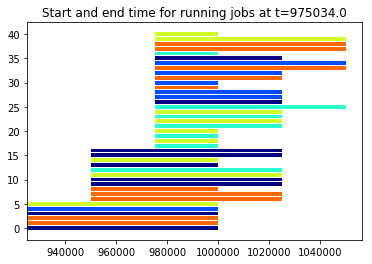

In [322]:
gantt_plot(running_at.job_id, 
           running_at.start_time_ms, 
           running_at.end_time_ms, 
           colors_for_values(running_at.hostname))
plt.title("Start and end time for running jobs at t={}".format(df.start_time_ms.median()))

# Comparing simulation runs

In [351]:
compare_df = compare("simulator_files/experiments/big/out-trace.csv", 
                     "simulator_files/experiments/big/out-trace2.csv")

In [352]:
compare_df[abs(compare_df.ratio-1) > 0.001][["end_time_ms_x", "end_time_ms_y"]]

,end_time_ms_x,end_time_ms_y


In [342]:
compare_df[compare_df.start_time_ms_x != compare_df.start_time_ms_y][["submit_time_ms_x", "start_time_ms_x","submit_time_ms_y", "start_time_ms_y"]].sort_values("start_time_ms_x")

,submit_time_ms_x,start_time_ms_x,submit_time_ms_y,start_time_ms_y
